# **Khushdev Pandit**
# **Roll no: 2020211** 
# *Assignment Question-1*

In [ ]:
import os
from PIL import Image
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch.utils.data import TensorDataset
import torch.optim as optim
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.facecolor'] = 'white'
import torch.nn.functional as F
import cv2
import numpy as np
from torch.utils.data.sampler import SubsetRandomSampler
import pickle
from sklearn import manifold
import pandas as pd
import seaborn as sns
from sklearn.metrics import classification_report
import warnings
warnings.filterwarnings("ignore")

# **Q1 Part-1**

## **1(a)** *Download train 32x32.mat. Use 20% of the training dataset for validation and 10% for testing Initialize Weights & Biases*

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
import scipy.io
path_data = "/content/drive/MyDrive/ECE344: CV (Computer Vision)/Assignments/Assignment-1/Q1/train_32x32.mat"
mat = scipy.io.loadmat(path_data)

print('Keys:', mat.keys())
for key in mat.keys():
    if key != 'X' and key != 'y':
        print(key,': ', mat[key])

lenx = len(mat['X'][0][0][0])
leny = len(mat['y'])
print('Num of images:',(lenx, leny))

Keys: dict_keys(['__header__', '__version__', '__globals__', 'X', 'y'])
__header__ :  b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Mon Dec  5 21:09:26 2011'
__version__ :  1.0
__globals__ :  []
Num of images: (73257, 73257)


In [ ]:
print(mat['X'][:,:,:,0].shape)
print(mat['y'][0])

(32, 32, 3)
[1]


Class/Labels:  [ 1  2  3  4  5  6  7  8  9 10]
Labels count distribution


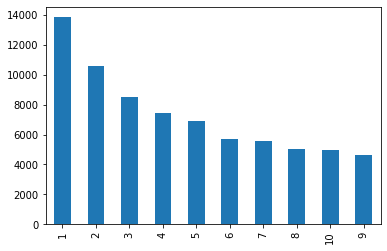

In [ ]:
print("Class/Labels: ", np.unique(mat['y']))
print("Labels count distribution")
pd.Series(mat['y'][:,0]).value_counts().plot(kind='bar');

Class/Labels:  [0 1 2 3 4 5 6 7 8 9]
Labels count distribution


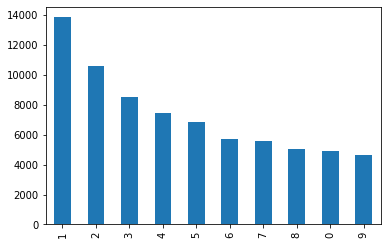

In [ ]:
indices_10 = (mat['y'] == 10)
mat['y'][indices_10] = 0

print("Class/Labels: ", np.unique(mat['y']))
print("Labels count distribution")
pd.Series(mat['y'][:,0]).value_counts().plot(kind='bar');

In [ ]:
train_size = int(lenx*0.70)
val_size = int(lenx*0.20)
test_size = int(lenx*0.10)
print((train_size, val_size, test_size))

(51279, 14651, 7325)


In [ ]:
!pip install wandb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import wandb
wandb.login()

wandb: Currently logged in as: khushdev20211 (cv_assignment). Use `wandb login --relogin` to force relogin


True

In [ ]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
print(device)

cpu


## **1(b)** *Create custom data loaders for all the splits (train, val and test) using PyTorch.*

(32, 32, 3) 8


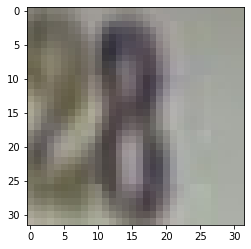

In [ ]:
class SVHNDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform
    
    def __len__(self):
        return len(self.data['X'][0][0][0])
    
    def __getitem__(self, idx, plot=False):
        img_data = self.data['X'][:,:,:,idx]
        img_label = self.data['y'][idx]
        if (self.transform is not None) and (plot==False):
            img_data = self.transform(img_data)
        return img_data, img_label[0]

dataset = SVHNDataset(mat)
img, label = dataset.__getitem__(13)
print(img.shape, label)
plt.imshow(img);

In [ ]:
g = torch.Generator()
g.manual_seed(42)

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

# Creating dataset
dataset = SVHNDataset(data=mat, transform=transform)
dataset_size = len(dataset)
indices = list(range(dataset_size))
np.random.shuffle(indices)

# Train, Validation and Test Split
test_index = indices[:test_size]
train_index = indices[test_size : test_size+train_size]
val_index = indices[-val_size:]

# SubsetRandomSampler for train, validation and test
train_sampler = SubsetRandomSampler(train_index, generator=g)
val_sampler = SubsetRandomSampler(val_index, generator=g)
test_sampler = SubsetRandomSampler(test_index, generator=g)

In [ ]:
batch_size = 1

# Custom data loaders for all the splits (train, val and test)
trainloader = DataLoader(dataset, sampler=train_sampler, batch_size=batch_size,num_workers=2)
valloader = DataLoader(dataset, sampler=val_sampler, batch_size=batch_size,num_workers=2)
testloader = DataLoader(dataset, sampler=test_sampler, batch_size=batch_size,num_workers=2)

print(len(trainloader), len(valloader), len(testloader))

51279 14651 7325


## **1(c)** *Visualize the data distribution across class labels for training and validation sets.*

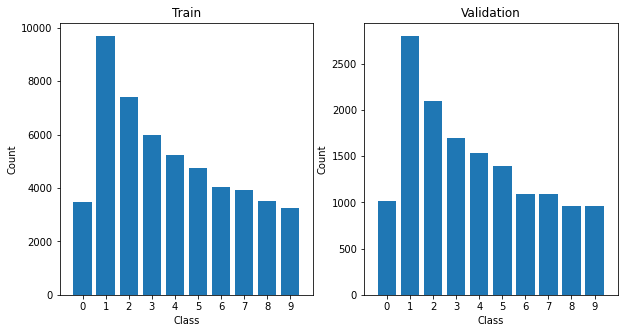

[3481, 9694, 7421, 5988, 5232, 4747, 4022, 3939, 3497, 3258]
[1015, 2802, 2098, 1694, 1537, 1398, 1096, 1091, 964, 956]


In [ ]:
import seaborn as sns

def class_distribution(data):
    classes = [0]*10
    for i in range(len(data)):
        img, label = data.dataset.__getitem__(i, plot=True)
        classes[label] += 1
    return classes

train_classes = class_distribution(trainloader)
val_classes = class_distribution(valloader)

# plot the class distribution in subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].bar(range(0,10), train_classes)
axes[0].set_title('Train')
axes[0].set_xlabel('Class')
axes[0].set_ylabel('Count')
axes[0].set_xticks(range(0,10))
axes[0].set_xlim(-1, 10)
axes[1].bar(range(0,10), val_classes)
axes[1].set_title('Validation')
axes[1].set_ylabel('Count')
axes[1].set_xlabel('Class')
axes[1].set_xticks(range(0,10))
axes[1].set_xlim(-1, 10)
plt.show()

print(train_classes)
print(val_classes)

Number of labels for digit '1' are greater than other labels.

In [ ]:
Part-1 Done

# **Q1 Part-2** **Training a CNN from scratch**

## **Q2 (a)** *Create a CNN architecture with 2 Convolution Layers having a kernel size of 3×3 and padding of 1. Use 32 feature maps for the first layer and 64 for the second. Finally add classification head to the conv layers. Use ReLU activation functions wherever applicable.*

In [ ]:
import torch.nn as nn

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # First Convolution Layer
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        # Second Convolution Layer
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()        
        # Classification Head
        self.fc = nn.Linear(in_features=64*32*32, out_features=10)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        # x = nn.MaxPool2d(kernel_size=2, stride=2)(x)
        x = self.conv2(x)
        x = self.relu2(x)        
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

## **Q2 (b)** *Train the model using the Cross-Entropy Loss. Use wandb to log the training and validation losses and accuracies.*

In [ ]:
# Model
model = CNN()

# Hyperparameters
lr=0.001
epochs=10
wd = 1e-3
batch_size = 64

# Custom data loaders for all the splits (train, val and test)
trainloader = DataLoader(dataset, sampler=train_sampler, batch_size=batch_size,num_workers=2)
valloader = DataLoader(dataset, sampler=val_sampler, batch_size=batch_size,num_workers=2)
testloader = DataLoader(dataset, sampler=test_sampler, batch_size=batch_size,num_workers=2)
print(len(trainloader), len(valloader), len(testloader))

802 229 115


In [ ]:
wandb.init(entity="cv_assignment", project="Assignment-1",name="Q1-Part2")
wandb.config = {"learning_rate": lr , "epochs": epochs, "batch_size": batch_size}  

In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=wd)

In [ ]:
epochs = 4

# Train the model
for epoch in range(epochs):
    print('Epoch: ', epoch+1)
    train_loss = 0.0
    correct = 0
    total = 0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        total += labels.size(0)
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == labels).sum().item()
    train_accuracy = 100 * correct / total
    print("Training Loss: {:.4f},  Training Accuracy: {:.4f}".format(train_loss / len(trainloader), train_accuracy))

    # Evaluate the model on validation set
    correct = 0
    total = 0
    val_loss = 0.0
    with torch.no_grad():
        for data in valloader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            val_loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    val_accuracy = 100 * correct / total
    print("Validation Loss: {:.4f},  Validation Accuracy: {:.4f}".format(val_loss/ len(valloader), val_accuracy))

    # Log the loss and accuracy to W&B
    wandb.log({'training_loss': train_loss / len(trainloader), 'validation_loss': val_loss / len(valloader),
               'training_accuracy': train_accuracy, 'validation_accuracy': val_accuracy})

print('Finished Training')

Epoch:  1
Training Loss: 0.9903,  Training Accuracy: 68.9717
Validation Loss: 0.6548,  Validation Accuracy: 80.9979
Epoch:  2
Training Loss: 0.5929,  Training Accuracy: 82.8331
Validation Loss: 0.6037,  Validation Accuracy: 82.3015
Epoch:  3
Training Loss: 0.5305,  Training Accuracy: 84.4712
Validation Loss: 0.5805,  Validation Accuracy: 82.7793
Epoch:  4
Training Loss: 0.4899,  Training Accuracy: 85.7213
Validation Loss: 0.5508,  Validation Accuracy: 83.9943
Finished Training


## **Q2 (c)** *Report the Accuracy and F1-Score on the test set. Also, log the confusion matrix using wandb.*

In [ ]:
from sklearn.metrics import confusion_matrix, f1_score

# Evaluate the model on test set
correct, total = 0, 0
x_test_img = []
y_test_true = []
y_test_pred = []
with torch.no_grad():
    for data in testloader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        x_test_img.extend(inputs.numpy().tolist())
        y_test_true.extend(labels.numpy().tolist())
        y_test_pred.extend(predicted.numpy().tolist())
test_accuracy = 100 * correct / total
print("Test set accuracy: {:.2f}%".format(test_accuracy))

# Compute the F1-score on testing set
f1 = f1_score(y_test_true, y_test_pred, average='macro')
print("Test set F1-score: {:.4f}".format(f1))

# Compute the confusion matrix for the Predictions
cm = confusion_matrix(y_test_true, y_test_pred)

# Logging the confusion matrix to W&B
wandb.log({'confusion_matrix': wandb.Image(cm, caption='Confusion Matrix')})

Test set accuracy: 84.45%
Test set F1-score: 0.8316


In [ ]:
# ✨ W&B: Save Model
torch.save(model.state_dict(),"cnn_q1_b.pth")
artifact = wandb.Artifact('model', type='model')
artifact.add_file('cnn_q1_b.pth')
wandb.log_artifact(artifact)
wandb.finish()

training_accuracy,▁▇▇█
training_loss,█▂▂▁
validation_accuracy,▁▄▅█
validation_loss,█▅▃▁
training_accuracy,85.72125
training_loss,0.48988
validation_accuracy,83.99427
validation_loss,0.55084


## **Q2 (d)** *For each class in the test set, visualize any 3 images that were misclassified along with the predicted class label. Analyze why the model could possibly be failing in these cases. Is this due to the fact that image looks much similar to the predicted class than the actual ground truth or something else?*

In [ ]:
import warnings
warnings.filterwarnings("ignore")

Visualization for Class:  0
Visualization for Class:  1
Visualization for Class:  2
Visualization for Class:  3
Visualization for Class:  4
Visualization for Class:  5
Visualization for Class:  6
Visualization for Class:  7
Visualization for Class:  8
Visualization for Class:  9


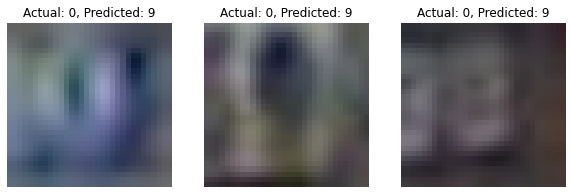

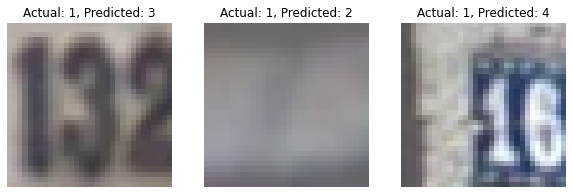

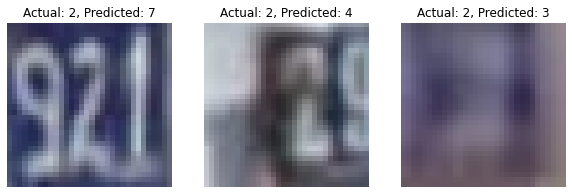

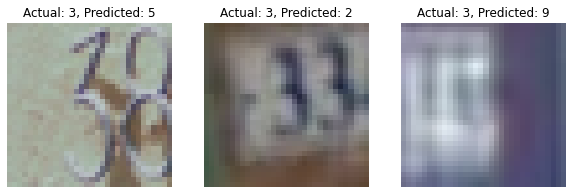

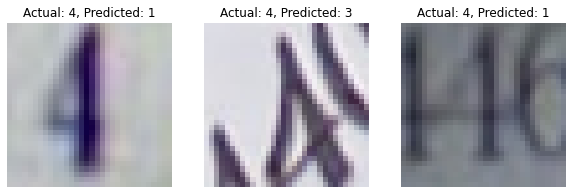

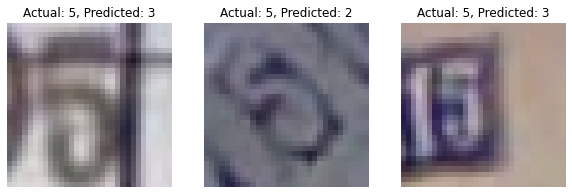

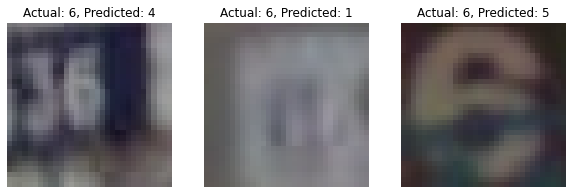

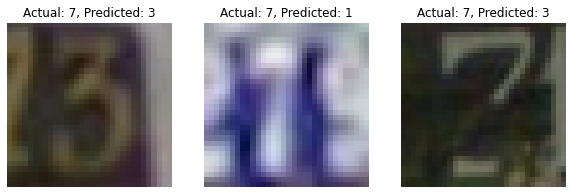

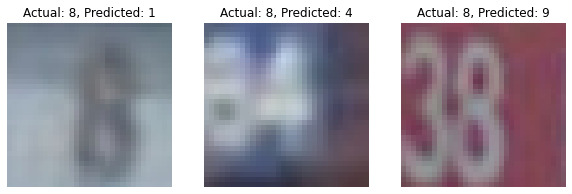

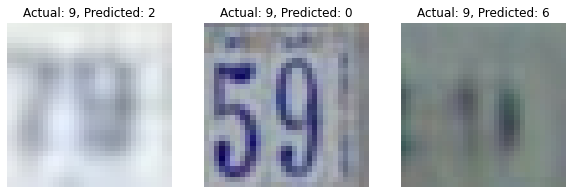

In [ ]:
x_test_img = np.array(x_test_img)
y_test_true = np.array(y_test_true)
y_test_pred = np.array(y_test_pred)

for out_class in range(10):
    print('Visualization for Class: ', out_class)
    class_ind = np.where(y_test_true == out_class)
    missclassfication_ind = np.where(y_test_pred[class_ind] != out_class)
    np.random.shuffle(missclassfication_ind)
    
    fig, axes = plt.subplots(1, 3, figsize=(10, 5))
    start = 4
    for i in range(start,start+3):
        # print(np.max(x_test_img[class_ind][missclassfication_ind][i]))
        img = x_test_img[class_ind][missclassfication_ind][i] / 2 + 0.5
        axes[i-start].imshow(img.transpose(1,2,0))
        axes[i-start].set_title('Actual: ' + str(out_class) + ', Predicted: ' + str(y_test_pred[class_ind][missclassfication_ind][i]))
        axes[i-start].axis('off')

The primary reason for digits misclassification is mainly beacause some images are not clear and presence of multiple digits in the image. In last row of images, we can see two images are entirely blur and second one has multiple digits. 


In [ ]:
Part-2 Done

# **Q1 Part-3**  **Fine-tuning a pretrained model**

## **Q3 (a)** *Train another classification model with a fine-tuned Resnet-18 (pre-trained on ImageNet) architecture using the same strategy used in Question1.2.(b) and again use wandb for logging the loss and accuracy.*

In [ ]:
def getData(batch_size = 64):
    # Creating dataset
    dataset = SVHNDataset(data=mat, transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
    ))
    dataset_size = len(dataset)
    indices = list(range(dataset_size))
    np.random.shuffle(indices)
    
    # Train, Validation and Test Split
    test_index = indices[:test_size]
    train_index = indices[test_size : test_size+train_size]
    val_index = indices[-val_size:]
    
    # SubsetRandomSampler for train, validation and test
    g = torch.Generator()
    g.manual_seed(42)
    train_sampler = SubsetRandomSampler(train_index, generator=g)
    val_sampler = SubsetRandomSampler(val_index, generator=g)
    test_sampler = SubsetRandomSampler(test_index, generator=g)
    
    # Custom data loaders for all the splits (train, val and test)
    trainloader = DataLoader(dataset, sampler=train_sampler, batch_size=batch_size,num_workers=2)
    valloader = DataLoader(dataset, sampler=val_sampler, batch_size=batch_size,num_workers=2)
    testloader = DataLoader(dataset, sampler=test_sampler, batch_size=batch_size,num_workers=2)
    return dataset, dataset_size, batch_size, trainloader, valloader, testloader

dataset, dataset_size, batch_size, trainloader, valloader, testloader = getData()
print(len(trainloader), len(valloader), len(testloader))

802 229 115


In [ ]:
# Load the pre-trained ResNet-18 model
model = models.resnet18(pretrained=True)

# Freeze none of layers
for param in model.parameters():
    param.requires_grad = True
model.fc.requires_grad = True

# Replace the last fully connected layer with a new one with the desired number of classes
model.fc = nn.Linear(model.fc.in_features, 10)

# Define the loss function and optimizer
lr = 0.001
epochs = 5
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-3)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [ ]:
wandb.init(entity="cv_assignment", project="Assignment-1",name="Q1-Part3")
wandb.config = {"learning_rate": lr , "epochs": epochs, "batch_size": batch_size}  

wandb: Currently logged in as: khushdev20211 (cv_assignment). Use `wandb login --relogin` to force relogin


In [ ]:
epochs = 4

# Train the model
for epoch in range(epochs):
    print('Epoch: ', epoch+1)
    train_loss = 0.0
    correct = 0
    total = 0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        total += labels.size(0)
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == labels).sum().item()
    train_accuracy = 100 * correct / total
    print("Training Loss: {:.4f},  Training Accuracy: {:.4f}".format(train_loss / len(trainloader), train_accuracy))

    # Evaluate the model on validation set
    correct = 0
    total = 0
    val_loss = 0.0
    with torch.no_grad():
        for data in valloader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            val_loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    val_accuracy = 100 * correct / total
    print("Validation Loss: {:.4f},  Validation Accuracy: {:.4f}".format(val_loss/ len(valloader), val_accuracy))

    # Log the loss and accuracy to W&B
    wandb.log({'training_loss': train_loss / len(trainloader), 'validation_loss': val_loss / len(valloader),
               'training_accuracy': train_accuracy, 'validation_accuracy': val_accuracy})

print('Finished Training')

Epoch:  1
Training Loss: 0.6140,  Training Accuracy: 81.0000
Validation Loss: 0.5055,  Validation Accuracy: 84.9294
Epoch:  2
Training Loss: 0.3872,  Training Accuracy: 88.6893
Validation Loss: 0.3976,  Validation Accuracy: 88.3694
Epoch:  3
Training Loss: 0.3388,  Training Accuracy: 90.2436
Validation Loss: 0.3677,  Validation Accuracy: 89.3113
Epoch:  4
Training Loss: 0.3082,  Training Accuracy: 91.1114
Validation Loss: 0.3489,  Validation Accuracy: 89.8778
Finished Training


## **Q3 (b)** *Report the Accuracy and F1-Score on the test set. Also, log the confusion matrix using wandb*

In [ ]:
from sklearn.metrics import confusion_matrix, f1_score

# Evaluate the model on test set
correct, total = 0, 0
x_test_img = []
y_test_true = []
y_test_pred = []
with torch.no_grad():
    for data in testloader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        x_test_img.extend(inputs.numpy().tolist())
        y_test_true.extend(labels.numpy().tolist())
        y_test_pred.extend(predicted.numpy().tolist())
test_accuracy = 100 * correct / total
print("Test set accuracy: {:.2f}%".format(test_accuracy))

# Compute the F1-score on testing set
f1 = f1_score(y_test_true, y_test_pred, average='macro')
print("Test set F1-score: {:.4f}".format(f1))

# Compute the confusion matrix for the Predictions
cm = confusion_matrix(y_test_true, y_test_pred)

# Logging the confusion matrix to W&B
wandb.log({'confusion_matrix': wandb.Image(cm, caption='Confusion Matrix')})

Test set accuracy: 90.63%
Test set F1-score: 0.9000


In [ ]:
# ✨ W&B: Save Model
torch.save(model, 'resnet18model_q1_c.pt')
torch.save(model.state_dict(),"resnet18_q1_c.pth")
artifact = wandb.Artifact('model', type='model')
artifact.add_file('resnet18model_q1_c.pt')
artifact.add_file('resnet18_q1_c.pth')
wandb.log_artifact(artifact)
wandb.finish()

training_accuracy,▁▆▇█
training_loss,█▃▂▁
validation_accuracy,▁▆▇█
validation_loss,█▃▂▁
training_accuracy,91.11137
training_loss,0.30821
validation_accuracy,89.87782
validation_loss,0.34894


## **Q3 (c)** *For deep neural networks, typically, the backbone is the part of a model (initial layers) that is used to extract feature representations (or simply features) from the raw input data, which can then used for classification or some other related task. These features are expressed as an n-dimensional vector, also known as a feature vector and the corresponding vector space is referred to as the feature space. As the training progresses and the classifier learns to classify the input, the data samples belonging to the same class lie closer to each other in the feature space than other data samples. For input samples from the training and validation sets, extract the feature vectors using the backbone (ResNet-18 in this case) and visualize them in the feature space using the tSNE plot in a 2-D Space. Also, visualize the tSNE plot of the validation set in a 3D-Space.*

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import scipy.io
path_data = "/content/drive/MyDrive/ECE344: CV (Computer Vision)/Assignments/Assignment-1/Q1/train_32x32.mat"
mat = scipy.io.loadmat(path_data)

indices_10 = (mat['y'] == 10)
mat['y'][indices_10] = 0

In [ ]:
class SVHNDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform
    
    def __len__(self):
        return len(self.data['X'][0][0][0])
    
    def __getitem__(self, idx, plot=False):
        img_data = self.data['X'][:,:,:,idx]
        img_label = self.data['y'][idx]
        if self.transform:
            img_data = self.transform(img_data)
        return img_data, img_label[0]

# Transform
g = torch.Generator()
g.manual_seed(42)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

# Creating dataset
dataset = SVHNDataset(data=mat, transform=transform)
dataset_size = len(dataset)
indices = list(range(dataset_size))
np.random.shuffle(indices)

# Train, Validation and Test Split
train_size = int(dataset_size*0.70)
val_size = int(dataset_size*0.20)
test_size = int(dataset_size*0.10)
test_index = indices[:test_size]
train_index = indices[test_size : test_size+train_size]
val_index = indices[-val_size:]

# SubsetRandomSampler for train, validation and test
train_sampler = SubsetRandomSampler(train_index, generator=g)
val_sampler = SubsetRandomSampler(val_index, generator=g)
test_sampler = SubsetRandomSampler(test_index, generator=g)

# Custom data loaders for all the splits (train, val and test)
batch_size=64
trainloader = DataLoader(dataset, sampler=train_sampler, batch_size=64,num_workers=2)
valloader = DataLoader(dataset, sampler=val_sampler, batch_size=64,num_workers=2)
testloader = DataLoader(dataset, sampler=test_sampler, batch_size=64,num_workers=2)

In [ ]:
from torchvision.models import ResNet18_Weights

class ResNet18(torch.nn.Module):
    def __init__(self):
        super(ResNet18, self).__init__()
        self.model = models.resnet18(weights=ResNet18_Weights.DEFAULT)
        self.feature_extractor = torch.nn.Sequential(*list(self.model.children())[:-1])
        self.fc = nn.Linear(self.model.fc.in_features, 10)

    def forward(self, x):
        x = self.feature_extractor(x)
        x = torch.reshape(x, (batch_size, self.model.fc.in_features))
        x = self.fc(x)
        return x

    def forward_backbone(self, x):
        x = self.feature_extractor(x)
        x = torch.reshape(x, (batch_size, self.model.fc.in_features))
        return x

In [ ]:
# Load the pre-trained ResNet-18 model
resnet18model = ResNet18()

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet18model.parameters(), lr=0.001, weight_decay=1e-3)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [ ]:
n_dim_feature_vectors_train = []
n_dim_feature_vectors_val = []
epochs = 2

for epoch in range(epochs):
    print('Epoch: ', epoch+1)
    
    # Training of the resnet18model
    train_loss, correct, total = 0, 0, 0
    for i, data in enumerate(trainloader, 0):
        if i == len(trainloader)-1: break
        inputs, labels = data
        # inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = resnet18model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        total += labels.size(0)
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == labels).sum().item()
    train_accuracy = 100 * correct / total
    print("Training Loss: {:.4f},  Training Accuracy: {:.4f}".format(train_loss / len(trainloader), train_accuracy))

    # Evaluate the resnet18model on validation set
    correct, total, val_loss = 0, 0, 0
    with torch.no_grad():
        for i, data in enumerate(valloader, 0):
            if i == len(valloader)-1: break
            inputs, labels = data
            # inputs, labels = inputs.to(device), labels.to(device)
            outputs = resnet18model(inputs)
            val_loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    val_accuracy = 100 * correct / total
    print("Validation Loss: {:.4f},  Validation Accuracy: {:.4f}".format(val_loss/ len(valloader), val_accuracy))

print('Finished Training')

Epoch:  1
Training Loss: 0.3474,  Training Accuracy: 89.9306
Validation Loss: 0.3372,  Validation Accuracy: 90.1042
Epoch:  2
Training Loss: 0.3184,  Training Accuracy: 90.7830
Validation Loss: 0.3883,  Validation Accuracy: 88.4937
Finished Training


In [ ]:
import pickle 
with open('resnet18.pickle', 'wb') as pickle_out: 
    pickle.dump(resnet18model, pickle_out)

In [ ]:
import pickle
with open('resnet18.pickle', 'rb') as pickle_in:
    resnet18model = pickle.load(pickle_in)
    # print(resnet18model)

In [ ]:
train_features, train_labels = [], []
val_features, val_labels = [], []

for i, data in enumerate(trainloader, 0):
        if i == 200: break
        inputs, labels = data
        features = resnet18model.forward_backbone(inputs)
        train_features.append(features.detach().numpy())
        train_labels.append(labels.detach().numpy())
train_features = np.concatenate(train_features, axis=0)
train_labels = np.concatenate(train_labels, axis=0)

for i, data in enumerate(valloader, 0):
    if i == 200: break
    inputs, labels = data
    features = resnet18model.forward_backbone(inputs)
    val_features.append(features.detach().numpy())
    val_labels.append(labels.detach().numpy())
val_features = np.concatenate(val_features, axis=0)
val_labels = np.concatenate(val_labels, axis=0)

In [ ]:
train_features.shape, train_labels.shape, val_features.shape, val_labels.shape

((12800, 512), (12800,), (12800, 512), (12800,))

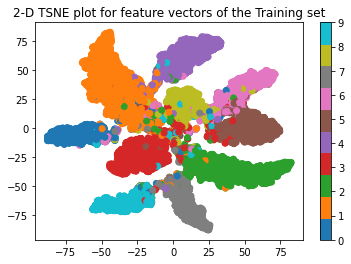

In [ ]:
from sklearn.manifold import TSNE

# 2-D t-SNE plot of the feature vectors of the validation set
tsne = TSNE(n_components=2)
tsne_result_train_2D = tsne.fit_transform(np.array(train_features))

plt.scatter(tsne_result_train_2D[:, 0], tsne_result_train_2D[:, 1], c=np.array(train_labels), cmap=plt.cm.get_cmap('tab10', len(np.unique(train_labels))))
plt.title('2-D TSNE plot for feature vectors of the Training set')
plt.colorbar()
plt.show()

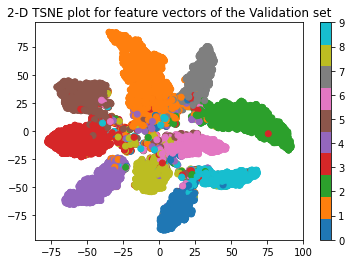

In [ ]:
from sklearn.manifold import TSNE

# 2-D t-SNE plot of the feature vectors of the validation set
tsne = TSNE(n_components=2)
tsne_result_val_2D = tsne.fit_transform(np.array(val_features))

plt.scatter(tsne_result_val_2D[:, 0], tsne_result_val_2D[:, 1], c=np.array(val_labels), cmap=plt.cm.get_cmap('tab10', len(np.unique(val_labels))))
# plt.scatter(tsne_result_val_2D[:, 0], tsne_result_val_2D[:, 1])
plt.title('2-D TSNE plot for feature vectors of the Validation set')
plt.colorbar()
plt.show()

3-D TSNE plot for feature vectors of the Validation set


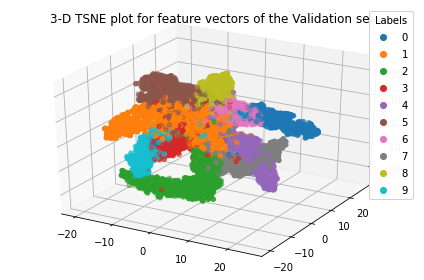

In [ ]:
# Project the feature vectors into 3D using t-SNE
tsne_3D = TSNE(n_components=3)
tsne_result_val_3D = tsne_3D.fit_transform(np.array(val_features))


# Plot the t-SNE results in 3D (using matplotlib's mplot3d toolkit)
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
scat_plot = ax.scatter(tsne_result_val_3D[:, 0], tsne_result_val_3D[:, 1],  tsne_result_val_3D[:, 2], c=val_labels, cmap=plt.cm.get_cmap('tab10', 10))
ax.set_title('3-D TSNE plot for feature vectors of the Validation set')
legend = ax.legend(*scat_plot.legend_elements(), title="Labels")
ax.add_artist(legend)
plt.tight_layout()
print('3-D TSNE plot for feature vectors of the Validation set')
plt.show()

In [ ]:
Part 3 Done...

# **Q1 Part-4  Data augmentation techniques**

## **Q4 (a)** *Use any 3 (or more) Data Augmentation techniques that are suitable for this problem. Remember that data augmentation techniques are used for synthetically adding more training data so that the model can train on more variety of data samples.*

In [ ]:
class SVHNDataset(Dataset):
    def __init__(self, data, ind, transform1=None, transform2=None):
        self.images = data['X'][:,:,:,ind]
        self.labels = data['y'][ind]
        self.transform1 = transform1
        self.transform2 = transform2
    
    def __len__(self):
        return len(self.images[0][0][0])
    
    def __getitem__(self, idx, test=False):
        img_data = self.images[:,:,:,idx].copy()
        img_label = self.labels[idx].copy()
        if  self.transform1 and  np.random.choice(2, 1) == 1:
            img_data = self.transform1(img_data)
        else:
            img_data = self.transform2(img_data)
        return img_data, img_label[0]

In [ ]:
transform1 = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=10),
    transforms.RandomCrop(size=(32, 32), padding=4),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])]
)
transform2 = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])]
)

# Creating dataset
dataset_size = len(mat['X'][0][0][0])
indices = list(range(dataset_size))
np.random.shuffle(indices)
train_size = int(dataset_size*0.70)
val_size = int(dataset_size*0.20)
test_size = int(dataset_size*0.10)
train_index = indices[test_size : test_size+train_size]
val_index = indices[-val_size:]
test_index = indices[:test_size]

# Train, Val, Test data split
train_data = SVHNDataset(data=mat, ind=train_index, transform1=transform1, transform2=transform2)
val_data = SVHNDataset(data=mat, ind=val_index, transform1=transform1, transform2=transform2)
test_data = SVHNDataset(data=mat, ind=test_index, transform1=transform2, transform2=transform2)

# Custom data loaders for all the splits (train, val and test)
batch_size = 64
trainloader_aug = DataLoader(train_data, batch_size=batch_size,num_workers=2)
valloader_aug = DataLoader(val_data, batch_size=batch_size,num_workers=2)
testloader_aug = DataLoader(test_data, batch_size=batch_size,num_workers=2)

print(len(trainloader_aug), len(valloader_aug), len(testloader_aug))

802 229 115


## **Q4 (b)**  *Follow the same steps as in Question 1.3.(a) to train the model.*

In [ ]:
# Load the pre-trained ResNet-18 model
model = models.resnet18(pretrained=True)

# Freeze none of layers
for param in model.parameters():
    param.requires_grad = True
model.fc.requires_grad = True

# Replace the last fully connected layer with a new one with the desired number of classes
model.fc = nn.Linear(model.fc.in_features, 10)

# Define the loss function and optimizer
lr = 0.001
epochs = 5
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-3)

In [ ]:
wandb.init(entity="cv_assignment", project="Assignment-1",name="Q1-Part4")
wandb.config = {"learning_rate": lr , "epochs": epochs, "batch_size": batch_size}  

In [ ]:
epochs = 4

# Train the model
for epoch in range(epochs):
    print('Epoch: ', epoch+1)
    train_loss = 0.0
    correct = 0
    total = 0
    for i, data in enumerate(trainloader_aug, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        total += labels.size(0)
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == labels).sum().item()
    train_accuracy = 100 * correct / total
    print("Training Loss: {:.4f},  Training Accuracy: {:.4f}".format(train_loss / len(trainloader_aug), train_accuracy))

    # Evaluate the model on validation set
    correct = 0
    total = 0
    val_loss = 0.0
    with torch.no_grad():
        for data in valloader_aug:
            inputs, labels = data
            outputs = model(inputs)
            val_loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    val_accuracy = 100 * correct / total
    print("Validation Loss: {:.4f},  Validation Accuracy: {:.4f}".format(val_loss/ len(valloader_aug), val_accuracy))

    # Log the loss and accuracy to W&B
    wandb.log({'training_loss': train_loss / len(trainloader_aug), 'validation_loss': val_loss / len(valloader_aug),
               'training_accuracy': train_accuracy, 'validation_accuracy': val_accuracy})

print('Finished Training')

Epoch:  1
Training Loss: 0.9498,  Training Accuracy: 68.9171
Validation Loss: 0.6385,  Validation Accuracy: 79.7215
Epoch:  2
Training Loss: 0.6036,  Training Accuracy: 81.1989
Validation Loss: 0.5247,  Validation Accuracy: 83.7144
Epoch:  3
Training Loss: 0.5254,  Training Accuracy: 83.9057
Validation Loss: 0.4854,  Validation Accuracy: 85.0317
Epoch:  4
Training Loss: 0.4879,  Training Accuracy: 85.1440
Validation Loss: 0.4664,  Validation Accuracy: 85.9873
Finished Training


## **Q4 (c)** *Report the Accuracy and F1-Score on the test set. Also, log the confusion matrix using wandb.*

In [ ]:
from sklearn.metrics import confusion_matrix, f1_score

# Evaluate the model on test set
correct, total = 0, 0
x_test_img = []
y_test_true = []
y_test_pred = []
with torch.no_grad():
    for data in testloader_aug:
        inputs, labels = data
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        x_test_img.extend(inputs.numpy().tolist())
        y_test_true.extend(labels.numpy().tolist())
        y_test_pred.extend(predicted.numpy().tolist())
test_accuracy = 100 * correct / total
print("Test set accuracy: {:.2f}%".format(test_accuracy))

# Compute the F1-score on testing set
f1 = f1_score(y_test_true, y_test_pred, average='macro')
print("Test set F1-score: {:.4f}".format(f1))

# Compute the confusion matrix for the Predictions
cm = confusion_matrix(y_test_true, y_test_pred)

# Logging the confusion matrix to W&B
wandb.log({'confusion_matrix': wandb.Image(cm, caption='Confusion Matrix')})

Test set accuracy: 88.20%
Test set F1-score: 0.8768


In [ ]:
# ✨ W&B: Save Model
torch.save(model, 'resnet18model_q1_4b.pt')
torch.save(model.state_dict(),"resnet18_q1_4b.pth")
artifact = wandb.Artifact('model', type='model')
artifact.add_file('resnet18model_q1_4b.pt')
artifact.add_file('resnet18_q1_4b.pth')
wandb.log_artifact(artifact)
wandb.finish()

training_accuracy,▁▆▇█
training_loss,█▃▂▁
validation_accuracy,▁▅▇█
validation_loss,█▃▂▁
training_accuracy,85.14402
training_loss,0.48788
validation_accuracy,85.9873
validation_loss,0.46641


# **Q1 Part-6** *Compare and comment on the performance of all three models.*

**CNN Model**

<div>
Training Accuracy: 85.7213<br>
Validation Accuracy: 83.9943<br>
Testset accuracy: 84.45%<br>
Testset F1-score: 0.8316<br>
</div>
<br>



**Resnet-18 Model**
<div>
Training Accuracy: 91.1114<br>
Validation Accuracy: 89.8778<br>
Test set accuracy: 90.63%<br>
Test set F1-score: 0.9000<br>
</div>
<br>



**Resnet-18 Model with Data augmentation**
<div>
Training Accuracy: 85.1440<br>
Validation Accuracy: 85.9873<br>
Test set accuracy: 88.20%<br>
 Test set F1-score: 0.8768<br>
</div>





The best model for the Image classification task is Resnet18 model architecture (without data augmentation). This is beacuse Resnet18 is a pretatined model and has a better deeper architecture than our Custom CNN. 
Resnet 18 with data augmentation modify the input images, so it makes the input images somewhat harder to classify and hence the performance with data augmentation is somewhat lesser.